#### Tutorial: https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [53]:
%%capture
!pip3 install -q -U watermark
!pip install -qq transformers

In [54]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import numpy as np

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [56]:
DATA = Path('/home/sharif/Documents/Challenges/nlp-with-disaster-tweets/data')
train, test = pd.read_csv(DATA/'train.csv'), pd.read_csv(DATA/'test.csv')

In [57]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [58]:
sample_txt = 'I just visited https://www.google.com/ and I hate what I see #antilove'

In [59]:
tokens = tokenizer.tokenize(sample_txt); tokens

['I',
 'just',
 'visited',
 'https',
 ':',
 '/',
 '/',
 'www',
 '.',
 'go',
 '##og',
 '##le',
 '.',
 'com',
 '/',
 'and',
 'I',
 'hate',
 'what',
 'I',
 'see',
 '#',
 'anti',
 '##love']

In [60]:
token_ids = tokenizer.convert_tokens_to_ids(tokens); token_ids

[146,
 1198,
 3891,
 18630,
 131,
 120,
 120,
 7001,
 119,
 1301,
 8032,
 1513,
 119,
 3254,
 120,
 1105,
 146,
 4819,
 1184,
 146,
 1267,
 108,
 2848,
 24040]

In [61]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
    truncation=True # lets check that
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [62]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,   146,  1198,  3891, 18630,   131,   120,   120,  7001,   119,
         1301,  8032,  1513,   119,  3254,   120,  1105,   146,  4819,  1184,
          146,  1267,   108,  2848, 24040,   102,     0,     0,     0,     0,
            0,     0])

In [63]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0, 0, 0, 0]])

In [64]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'I',
 'just',
 'visited',
 'https',
 ':',
 '/',
 '/',
 'www',
 '.',
 'go',
 '##og',
 '##le',
 '.',
 'com',
 '/',
 'and',
 'I',
 'hate',
 'what',
 'I',
 'see',
 '#',
 'anti',
 '##love',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [65]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [68]:
toke_lens = []
for txt in train.text:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    toke_lens.append(len(tokens))

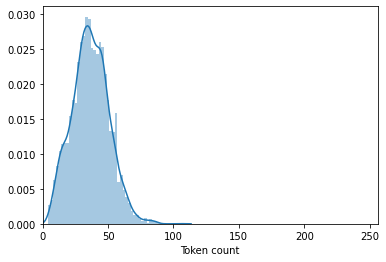

In [67]:
sns.distplot(toke_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [69]:
MAX_LEN = 120

In [70]:
class DS(Dataset):
    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self): return len(self.tweets)
    
    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(
          tweet,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
        )
        
        return {
          'tweet_text': tweet,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [71]:
df_train, df_valid = train_test_split(train, test_size=0.15)
df_valid, df_test = train_test_split(df_valid, test_size=0.2)

In [72]:
len(df_train), len(df_valid), len(df_test)

(6471, 913, 229)

In [73]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = DS(
        tweets=df.text.to_numpy(),
        targets=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [74]:
BATCH_SIZE = 12

In [75]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_valid, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [76]:
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [77]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([12, 120])
torch.Size([12, 120])
torch.Size([12])


In [78]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [79]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)

In [80]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [81]:
bert_model.config.hidden_size

768

In [82]:
pooled_output.shape

torch.Size([1, 768])

In [85]:
class Classifier(nn.Module):
    def __init__(self, n_classes):
        super(Classifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
            
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [86]:
%%capture
model = Classifier(2)
model.cuda()

In [87]:
input_ids = data['input_ids'].cuda()
attention_mask = data['attention_mask'].cuda()

In [88]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2178, 0.7822],
        [0.2505, 0.7495],
        [0.4724, 0.5276],
        [0.2801, 0.7199],
        [0.2628, 0.7372],
        [0.3048, 0.6952],
        [0.2744, 0.7256],
        [0.2036, 0.7964],
        [0.4474, 0.5526],
        [0.5277, 0.4723],
        [0.4953, 0.5047],
        [0.2496, 0.7504]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [89]:
EPOCHS = 1000

optim = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optim,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().cuda()

In [90]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [91]:
def train_epoch(model, data_loader, loss_fn, optim, device, scheduler, n_examples):
    model.train()
    
    losses = []
    correct_predictions = 0
    
    for i, d in enumerate(data_loader):
        #if i % 50 == 0: print(f'{i}/{len(data_loader)}')
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optim.step()
        scheduler.step()
        optim.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)

In [92]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for i, d in enumerate(data_loader):
            #if i % 50 == 0: print(f'{i}/{len(data_loader)}')
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [93]:
from collections import defaultdict

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optim, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_valid)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/1000
----------
Train loss 0.5597116585131044 accuracy 0.7474887961675166
Val   loss 0.4740877526921111 accuracy 0.8094194961664841

Epoch 2/1000
----------
Train loss 0.44319131808286466 accuracy 0.831710709318498
Val   loss 0.48180930751871753 accuracy 0.8127053669222344

Epoch 3/1000
----------
Train loss 0.3657563453402232 accuracy 0.8704991500540875
Val   loss 0.5777102308710674 accuracy 0.7864184008762322

Epoch 4/1000
----------
Train loss 0.31077889038284345 accuracy 0.9139236594034925
Val   loss 0.7529463730571042 accuracy 0.7765607886089814

Epoch 5/1000
----------
Train loss 0.2560442836028179 accuracy 0.9335496832019782
Val   loss 0.7953473041378348 accuracy 0.8083242059145673

Epoch 6/1000
----------
Train loss 0.21853878349367598 accuracy 0.9476124246638851
Val   loss 0.8772562811114861 accuracy 0.7951807228915663

Epoch 7/1000
----------
Train loss 0.18476322947794366 accuracy 0.956884561891516
Val   loss 0.9201021408178396 accuracy 0.7820372398685651

Epoch 8/10